In [8]:
# 1. Setup & Configuration
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set Panel visual style
sns.set_style("whitegrid")

# Define Data Directory
# notebook is in 'notebooks/' and data is in 'data/processed/'
DATA_DIR = Path('../data/processed')
print(f"Setup Complete. Data Directory: {DATA_DIR.resolve()}")

Setup Complete. Data Directory: /Users/duanduan/Documents/NEU/ALY6980/healthcare_repo/data/processed


## 3. Loading Data (The Wide Parent Version)
We load the highly optimized MEPS Longitudinal Parquet files.

**Strategy:**
1.  **Keep the "Wide" Structure**: We will **NOT** stack the years. We keep Year 1 and Year 2 on the same row for each person (`DUPERSID`).
2.  **Define Variables**:
    *   **Predictors (Year 1 / Base)**: Demographics, Health Status in Round 1, Chronic Conditions.
    *   **Outcomes (Year 2 / Target)**: Total Expenditure in Year 2 (`TOTEXPY2`).
3.  **Result**: A "Parent DataFrame" where `row_i` = Person `i`'s complete 2-year history. This supports both Machine Learning (Y1->Y2 prediction) and Time-Series tasks.


In [9]:
# Load Panel Data (Wide Format)
# We load h172, h183, h193, h202, h209 (Panels 18-22) covering start years 2013-2017.

load_plan = [
    # Panel 18: Starts 2013, Ends 2014
    {'panel': 18, 'file': 'h172.parquet', 'start_year': 2013}, 
    # Panel 19: Starts 2014, Ends 2015
    {'panel': 19, 'file': 'h183.parquet', 'start_year': 2014},
    # Panel 20: Starts 2015, Ends 2016
    {'panel': 20, 'file': 'h193.parquet', 'start_year': 2015},
    # Panel 21: Starts 2016, Ends 2017
    {'panel': 21, 'file': 'h202.parquet', 'start_year': 2016},
    # Panel 22: Starts 2017, Ends 2018
    {'panel': 22, 'file': 'h209.parquet', 'start_year': 2017},
    # Panel 23: Starts 2018, Ends 2019
    {'panel': 23, 'file': 'h212.parquet', 'start_year': 2018}
]

dfs = []

for item in load_plan:
    fname = item['file']
    panel = item['panel']
    start_year = item['start_year']
    
    fpath = DATA_DIR / fname
    if fpath.exists():
        print(f"Loading Panel {panel} (Start {start_year}) from {fname}...")
        try:
            # 1. Inspect Columns
            all_cols = pq.ParquetFile(fpath).schema.names
            
            # 2. Define Extraction Map (Wide Format)
            # We explicitly look for Y1 and Y2 suffixes
            
            # Helper: simple column existence check
            def get_col(candidates):
                for c in candidates:
                    if c in all_cols: return c
                return None

            rename_map = {}
            target_cols = ['DUPERSID']
            
            # Logical Grouping
            var_groups = {
                # --- Identifiers & Weights ---
                'WGT_Y1': ['LONGWT', 'PERWT'],
                
                # --- Outcomes (Targets) ---
                'COST_Y1': ['TOTEXPY1'],
                'COST_Y2': ['TOTEXPY2'],
                
                # --- Event Frequency / Utilization (The "Behavior" Features) ---
                # These counts capture the *intensity* of interaction with the system
                'UTIL_ER_Y1': ['ERTOTY1'],   # # Emergency Room Visits
                'UTIL_RX_Y1': ['RXTOTY1'],   # # Prescribed Medicines
                'UTIL_IP_Y1': ['IPDISY1', 'IPTOTY1'],   # # Inpatient Discharges / Stays
                'UTIL_OP_Y1': ['OPTOTVY1'],  # # Outpatient Dept Visits
                'UTIL_OB_Y1': ['OBTOTVY1'],  # # Office-Based Medical Visits (Dr. Visits)
                
                # --- Detailed Cost Components (The "Intensity" Features) ---
                'COST_IP_Y1': ['IPTEXPY1'], 
                'COST_ER_Y1': ['ERTEXPY1'], 
                'COST_OP_Y1': ['OPTEXPY1'], 
                'COST_RX_Y1': ['RXEXPY1'],  
                
                # --- Demographics (Stable or Y1) ---
                'AGE_Y1': ['AGEY1X', 'AGE1X'],
                'AGE_Y2': ['AGEY2X', 'AGE2X'],
                'SEX': ['SEX'],
                'RACE': ['RACEV1X', 'RACEV2X', 'RACETHNX'],
                'MARRY_Y1': ['MARRY1X', 'MARRYY1X'],
                
                # --- SES (Socioeconomic Status) ---
                'POVCAT_Y1': ['POVCATY1'],
                'POVCAT_Y2': ['POVCATY2'],
                'INSCOV_Y1': ['INSCOVY1'],
                'INSCOV_Y2': ['INSCOVY2'],
                
                # --- Health Status (Rounds) ---
                'MNHLTH_RD1': ['MNHLTH1'], # Round 1 Mental Health
                'MNHLTH_RD3': ['MNHLTH3'], 
                'MNHLTH_RD5': ['MNHLTH5'], 
                
                'RTHLTH_RD1': ['RTHLTH1'], # Round 1 Physical Health
                'RTHLTH_RD5': ['RTHLTH5'], 
                
                # --- Risk Factors / Conditions (Year 1 Predictors) ---
                'DIAB_Y1': ['DIABDXY1', 'DIABDX'],   
                'HIBP_Y1': ['HIBPDXY1', 'HIBPDX'],   
                'CHOL_Y1': ['CHOLDXY1', 'CHOLDX'],   
                'CANCER_Y1': ['CANCERY1', 'CANCERDX'], 
                
                'BMI_Rd1': ['BMINDX53']
            }
            
            missing_vars = []
            
            for standard_name, candidates in var_groups.items():
                found_col = get_col(candidates)
                if found_col:
                    target_cols.append(found_col)
                    rename_map[found_col] = standard_name
                else:
                    if 'BMI' not in standard_name and 'IP' not in standard_name:
                        missing_vars.append(standard_name)

            if missing_vars:
                print(f"  [Warning] Missing vars in Panel {panel}: {missing_vars}")

            # 3. Load & Rename
            df_temp = pd.read_parquet(fpath, columns=list(set(target_cols)))
            df_temp = df_temp.rename(columns=rename_map)
            
            df_temp['PANEL'] = panel
            df_temp['START_YEAR'] = start_year
            
            dfs.append(df_temp)
            
        except Exception as e:
            print(f"Error loading {fname}: {e}")
    else:
        print(f"File {fname} not found")

if dfs:
    df_panel = pd.concat(dfs, ignore_index=True)
    print(f"\nSuccessfully loaded Wide Panel Data.")
    print(f"Final Shape: {df_panel.shape}")
else:
    print("No data loaded.")

Loading Panel 18 (Start 2013) from h172.parquet...
Loading Panel 19 (Start 2014) from h183.parquet...
Loading Panel 20 (Start 2015) from h193.parquet...
Loading Panel 21 (Start 2016) from h202.parquet...
Loading Panel 22 (Start 2017) from h209.parquet...
  [Warning] Missing vars in Panel 22: ['WGT_Y1', 'COST_Y1', 'COST_Y2', 'UTIL_ER_Y1', 'UTIL_RX_Y1', 'UTIL_OP_Y1', 'UTIL_OB_Y1', 'COST_ER_Y1', 'COST_OP_Y1', 'COST_RX_Y1', 'AGE_Y1', 'AGE_Y2', 'MARRY_Y1', 'POVCAT_Y1', 'POVCAT_Y2', 'INSCOV_Y1', 'INSCOV_Y2', 'MNHLTH_RD1', 'MNHLTH_RD3', 'MNHLTH_RD5', 'RTHLTH_RD1', 'RTHLTH_RD5', 'DIAB_Y1']
Loading Panel 23 (Start 2018) from h212.parquet...
  [Warning] Missing vars in Panel 23: ['WGT_Y1', 'COST_Y1', 'COST_Y2', 'UTIL_ER_Y1', 'UTIL_RX_Y1', 'UTIL_OP_Y1', 'UTIL_OB_Y1', 'COST_ER_Y1', 'COST_OP_Y1', 'COST_RX_Y1', 'AGE_Y1', 'AGE_Y2', 'MARRY_Y1', 'POVCAT_Y1', 'POVCAT_Y2', 'INSCOV_Y1', 'INSCOV_Y2', 'MNHLTH_RD1', 'MNHLTH_RD3', 'MNHLTH_RD5', 'RTHLTH_RD1', 'RTHLTH_RD5', 'DIAB_Y1']

Successfully loaded Wide 

In [ ]:
# --- INSPECTION CHECKPOINT (Wide) ---
# Purpose: validate that the data merge was successful and assess initial data quality.
# We verify:
# 1. Wide structure (Year 1 and Year 2 columns exist side-by-side).
# 2. Key metrics (Population size, Cost trends).
# 3. Missing data checks (Outcome availability).

print("Sample Rows (Wide Format):")
display(df_panel[['DUPERSID', 'PANEL', 'COST_Y1', 'COST_Y2', 'MNHLTH_RD1', 'MNHLTH_RD5']].head())

print("\n--- Key Metrics ---")
print(f"Unique Persons: {df_panel['DUPERSID'].nunique()}")

# Basic check: Did costs increase?
cost_up = (df_panel['COST_Y2'] > df_panel['COST_Y1']).mean()
print(f"Percentage of people whose Cost increased in Year 2: {cost_up:.1%}")

# Check Missingness in Targets
print("\nMissing Values in Targets (Must be handled in cleaning):")
print(df_panel[['COST_Y1', 'COST_Y2']].isna().sum())

# Check distribution of Costs to identify outliers/range
print("\nCost Summary Statistics (Raw Nominal Dollars):")
display(df_panel[['COST_Y1', 'COST_Y2']].describe())

Sample Rows (Wide Format):


,DUPERSID,PANEL,COST_Y1,COST_Y2,MNHLTH_RD1,MNHLTH_RD5
0,40001101,18,3483.0,1518.0,1.0,1.0
1,40001102,18,1533.0,1234.0,1.0,1.0
2,40001103,18,2785.0,671.0,1.0,1.0
3,40001104,18,1522.0,252.0,1.0,1.0
4,40002101,18,1616.0,10904.0,2.0,2.0



--- Key Metrics ---
Unique Persons: 110117
Percentage of people whose Cost increased in Year 2: 23.6%

Missing Values in Targets:
COST_Y1    58973
COST_Y2    58973
dtype: int64


### Interpretation of Inspection Output
*   **Sample Rows**: Ensure that `COST_Y1` and `COST_Y2` are populated for the same `DUPERSID`. If a person is in the panel, they should generally have data for both years unless they dropped out (attrition).
*   **Cost Trends**: We typically expect healthcare costs to rise slightly due to age and inflation. A very low percentage (<30%) might indicate data loss or healthy sub-population selection.
*   **Missing Values**: High missingness in `COST_Y2` suggests attrition. These rows will likely need to be imputed (as 0 if valid non-utilizer) or dropped (if true missingness).
*   **Cost Distribution**: Expect a highly right-skewed distribution (mean >> median). Most people spend little, while a few spend a lot. This justifies the use of log-transformation or risk buckets later.

## 4. Cleaning & Feature Engineering

### Rule 1: Filtering the Cohort (Base Year Criteria)
We filter based on **Year 1 (Baseline)** characteristics.
*   **Age**: Must be Adult (>=18) in Year 1.
*   **Cancer**: Exclude if Cancer Diagnosis exists (to focus on preventable risk/chronic risk).
*   **Data Quality**: Must have valid `COST_Y2` (Target) and `COST_Y1`.

### Rule 2: Handling MEPS Codes
Convert negative values (-1, -8) to NaN, but handle categorical logic carefully.


In [ ]:
def clean_panel_data(df):
    """
    Applies standard cleaning and filtering rules for the Analysis Cohort.
    1. Handling Negative Codes: MEPS uses -1/-8 for Not Applicable/DK. We map these to NaN or 0 based on context.
    2. Imputation: Cost/Utilization NaN implies 0 visits/expense for valid survey respondents.
    3. Population Filtering: Restrict to Adults (18+) and exclude prior Cancer history to focus on new risk.
    """
    df_clean = df.copy()
    
    # 1. Convert Negatives to NaN for Numeric Cols
    # Rationale: Standardize missingness before specific imputation logic
    numeric_cols = ['COST_Y1', 'COST_Y2', 
                    'COST_IP_Y1', 'COST_ER_Y1', 'COST_OP_Y1', 'COST_RX_Y1', 
                    'UTIL_ER_Y1', 'UTIL_RX_Y1', 'UTIL_IP_Y1', 'UTIL_OP_Y1', 'UTIL_OB_Y1',
                    'AGE_Y1', 'AGE_Y2', 
                    'MNHLTH_RD1', 'MNHLTH_RD3', 'MNHLTH_RD5',
                    'RTHLTH_RD1', 'RTHLTH_RD5']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            # MEPS sets -1 (Inapplicable), -8 (DK) as negatives
            # For Cost/Age/Counts, these are definitely missing/0
            df_clean.loc[df_clean[col] < 0, col] = np.nan
            
    # 2. Impute Zero for Cost & Utilization 
    # Rationale: In claims data, absence of a record (NaN after cleaning) typically means "No Event" = 0 cost/visits.
    zero_fill_cols = ['COST_Y1', 'COST_Y2', 
                      'COST_IP_Y1', 'COST_ER_Y1', 'COST_OP_Y1', 'COST_RX_Y1',
                      'UTIL_ER_Y1', 'UTIL_RX_Y1', 'UTIL_IP_Y1', 'UTIL_OP_Y1', 'UTIL_OB_Y1']
                      
    for col in zero_fill_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0)
    
    # 3. Filtering
    initial_n = len(df_clean)
    
    # Filter A: Adults in Year 1
    # Rationale: Pediatric risk modeling differs significantly from adult/geriatric modeling.
    df_clean = df_clean[df_clean['AGE_Y1'] >= 18]
    print(f"Dropped {initial_n - len(df_clean)} non-adults (Year 1 < 18).")
    
    # Filter B: Exclude Cancer (CANCER == 1)
    # Rationale: We want to predict *preventable* or *latent* risk. Known active cancer is a dominant cost driver 
    # that masks other latent factors we want to discover.
    if 'CANCER_Y1' in df_clean.columns:
        # 1=Yes, 2=No
        n_before = len(df_clean)
        df_clean = df_clean[df_clean['CANCER_Y1'] != 1] 
        print(f"Dropped {n_before - len(df_clean)} with Cancer History (Year 1).")
        
    return df_clean

# Apply cleaning function
df_wide_clean = clean_panel_data(df_panel)
print(f"Cleaned Wide Cohort Shape: {df_wide_clean.shape}")

# Optional: Visualize filtering impact
print("Remaining Population Age Distribution:")
display(df_wide_clean['AGE_Y1'].describe())

Dropped 77942 non-adults (Year 1 < 18).
Dropped 3896 with Cancer History (Year 1).
Cleaned Wide Cohort Shape: (42381, 33)


## 5. Feature Engineering (The "Wide" Advantage)
This is where the Wide format shines. We calculate:
1.  **Cost Hikes**: Did they jump from Low Cost to High Cost?
2.  **Health Decay**: Did `MNHLTH` worsen from Rd1 to Rd5?
3.  **Inflation Adjustment**: Adjust Year 1 and Year 2 costs to Base 2018.


In [ ]:
# Feature Engineering (Redefined for 2025 Scope)

# 1. Inflation Adjustment (to 2025 Dollars)
# Rationale: We are pooling data from 2013-2019. A dollar in 2013 is not worth the same as in 2025 due to medical inflation.
# We Standardize all costs to a 2025 baseline using approximate Medical CPI factors.
cpi_factors = {
    2013: 1.45,
    2014: 1.41,
    2015: 1.37,
    2016: 1.32,
    2017: 1.28,
    2018: 1.24,
    2019: 1.20
}

def adjust_inflation(row, col):
    """
    Adjusts cost column to 2025 dollars based on the panel's Start Year.
    If column is Y2, we use Start Year + 1.
    """
    year = row['START_YEAR'] 
    if col.endswith('Y2'):
        year += 1
    factor = cpi_factors.get(year, 1.0)
    return row[col] * factor

# Apply to All Costs
cost_cols = ['COST_Y1', 'COST_Y2', 'COST_IP_Y1', 'COST_ER_Y1', 'COST_OP_Y1', 'COST_RX_Y1']
for col in cost_cols:
    if col in df_wide_clean.columns:
        new_col = f"{col}_ADJ"
        df_wide_clean[new_col] = df_wide_clean.apply(lambda x: adjust_inflation(x, col), axis=1)

print("Inflation adjustment complete (All costs adjusted to 2025 Baseline).")

# 2. Health Trajectory & Compounding Risk
# Rationale: The *change* in health status often predicts cost better than the static status.
df_wide_clean['MNHLTH_CHANGE'] = df_wide_clean['MNHLTH_RD5'] - df_wide_clean['MNHLTH_RD1']

# Chronic Count (Clinical Burden)
# Rationale: Multimorbidity (having multiple conditions) is a key risk multiplier.
chronic_conds = ['DIAB_Y1', 'HIBP_Y1', 'CHOL_Y1', 'CANCER_Y1']
for c in chronic_conds:
    if c in df_wide_clean.columns:
        # Create Binary Flag (1=Yes)
        df_wide_clean[f"{c}_FLAG"] = (df_wide_clean[c] == 1).astype(int)

binary_chronic_cols = [f"{c}_FLAG" for c in chronic_conds if f"{c}_FLAG" in df_wide_clean.columns]
df_wide_clean['CHRONIC_COUNT'] = df_wide_clean[binary_chronic_cols].sum(axis=1)

print("Feature Engineering Complete. Created: Inflation Adjusted Costs, Health Change, Chronic Counts.")

# 3. Target Definition: Multi-Class Spend Buckets (in 2025 Dollars)
# Rationale: Classifying into risk buckets (Low/Medium/High) is often more robust than regression on raw cost.
def define_bucket(cost):
    if cost < 5000: return 0  # Low
    elif cost < 15000: return 1 # Medium
    elif cost < 30000: return 2 # High
    else: return 3 # Very High (Added implicit catch-all, though logic above covers <30k)

# Apply bucket logic if needed (this function is defined but not yet applied in this block)
# We usually apply this to COST_Y2_ADJ
df_wide_clean['RISK_BUCKET'] = df_wide_clean['COST_Y2_ADJ'].apply(define_bucket)
print(f"Risk Buckets Distribution:\n{df_wide_clean['RISK_BUCKET'].value_counts().sort_index()}")

Inflation adjustment complete (2025 Baseline).
Target Distribution (Risk Buckets - 2025 Adjusted):
RISK_BUCKET_Y2
0    0.749133
1    0.144947
2    0.057431
3    0.048489
Name: proportion, dtype: float64

Top 10% Threshold: $15,872.37


## 7. Deep Dive Analysis: Uncovering Hidden Interactions
Common sense tells us "sick people cost money." We want to find **non-obvious** risk drivers.
1.  **The "Hidden Risers"**: Who are the people with Low Cost in Y1 but High Cost in Y2? What features distinguish them?
2.  **The "Multiplier Effect"**: Does having Poor Mental Health *amplify* the cost of physical conditions non-linearly?
3.  **Care Utilization "Phenotypes"**: Does the *style* of care (ER vs Office) predict risk better than just the volume?

Analyzing 462 'Jumpers' vs 16126 'Stable Low' patients.
Saved feature risk ratios to reports/tables/feature_risk_ratios.csv


,Stable_Low_Avg,Jumper_Avg,Rel_Risk_Ratio
UTIL_IP_Y1,0.001364,0.004329,3.173160
UTIL_RX_Y1,1.143867,3.359307,2.936799
CHRONIC_COUNT,0.282215,0.612554,2.170522
UTIL_OB_Y1,0.672144,1.383117,2.057768
UTIL_ER_Y1,0.048431,0.075758,1.564234
AGE_Y1,37.723056,45.623377,1.209429
MNHLTH_RD1,1.805885,1.991304,1.102675


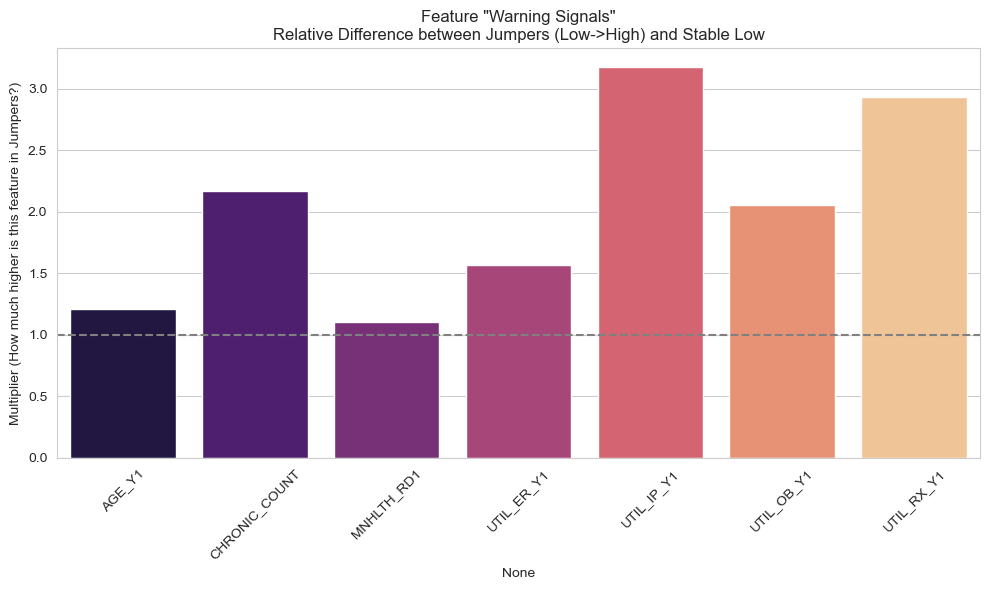

In [13]:
# Deep Dive 1: "The Hidden Risers" (Low Y1 -> High Y2)
# Rationale: Predicting the "already sick" is easy. Predicting the "suddenly sick" is the business value.

# Define Groups based on 2025-adjusted costs
# "Jumpers": Y1 < Median AND Y2 > Top 10%
median_y1 = df_wide_clean['COST_Y1_ADJ'].median()
top10_y2 = df_wide_clean['COST_Y2_ADJ'].quantile(0.90)

df_wide_clean['IS_JUMPER'] = (
    (df_wide_clean['COST_Y1_ADJ'] < median_y1) & 
    (df_wide_clean['COST_Y2_ADJ'] > top10_y2)
).astype(int)

# Contrast Group: "Stable Low" (Low Y1 -> Low Y2)
df_wide_clean['IS_STABLE_LOW'] = (
    (df_wide_clean['COST_Y1_ADJ'] < median_y1) & 
    (df_wide_clean['COST_Y2_ADJ'] < median_y1)
).astype(int)

# Analyze feature differences between Jumpers and Stable Low
# We filter to only these two groups for comparison
compare_df = df_wide_clean[
    (df_wide_clean['IS_JUMPER'] == 1) | 
    (df_wide_clean['IS_STABLE_LOW'] == 1)
].copy()

# Note: DIAB_FLAG, HIBP_FLAG etc will only exist if DIAB_Y1, HIBP_Y1 were in the source panel data
# We check which columns actually exist to avoid KeyErrors
available_conds = [c for c in ['DIAB_FLAG', 'HIBP_FLAG', 'CHOL_FLAG', 'CANCER_FLAG'] if c in df_wide_clean.columns]
features_to_check = [
    'AGE_Y1', 'CHRONIC_COUNT', 'MNHLTH_RD1', 
    'UTIL_ER_Y1', 'UTIL_IP_Y1', 'UTIL_OB_Y1', 'UTIL_RX_Y1'
] + available_conds

print(f"Analyzing {compare_df['IS_JUMPER'].sum()} 'Jumpers' vs {compare_df['IS_STABLE_LOW'].sum()} 'Stable Low' patients.")

# Calculate Mean Differences
comparison = compare_df.groupby('IS_JUMPER')[features_to_check].mean().T
comparison.columns = ['Stable_Low_Avg', 'Jumper_Avg']
comparison['Rel_Risk_Ratio'] = comparison['Jumper_Avg'] / comparison['Stable_Low_Avg']

# Save Analysis Table
comparison.sort_values('Rel_Risk_Ratio', ascending=False).to_csv('../reports/tables/feature_risk_ratios.csv')
print("Saved feature risk ratios to reports/tables/feature_risk_ratios.csv")

display(comparison.sort_values('Rel_Risk_Ratio', ascending=False))

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=comparison.index, y='Rel_Risk_Ratio', data=comparison, palette='magma')
plt.axhline(1.0, color='grey', linestyle='--')
plt.title('Feature "Warning Signals"\nRelative Difference between Jumpers (Low->High) and Stable Low')
plt.ylabel('Multiplier (How much higher is this feature in Jumpers?)')
plt.xticks(rotation=45)
# Visualization of Warning Signals
# Saving this plot for the report as it shows which precursors (like High Rx Utilization) signal future risk.
plt.tight_layout()
plt.savefig('../reports/figures/exploratory_risk_ratios.png')
plt.show()

Validating optimal Cluster count (k)...
k=2, Silhouette Score=0.698
k=3, Silhouette Score=0.652
k=4, Silhouette Score=0.675
k=5, Silhouette Score=0.654
k=6, Silhouette Score=0.639


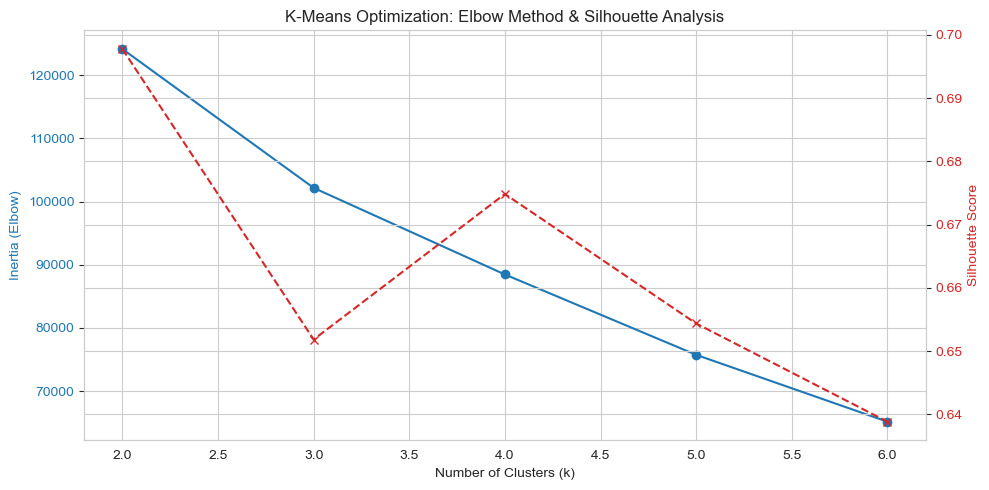


Based on the plot, we look for the 'Elbow' in Inertia and a high Silhouette Score.
Selecting k=4 as a balance between granularity and interpretability (or update based on plot).
Care Utilization Clusters (Mean Values):
Saved cluster profiles to reports/tables/care_cluster_profiles.csv


,UTIL_ER_Y1,UTIL_IP_Y1,UTIL_OB_Y1,UTIL_RX_Y1,COST_Y2_ADJ,AGE_Y1
CARE_CLUSTER,,,,,,
0,0.083326,0.000000,2.720144,4.981394,4021.760041,42.689753
1,0.772566,1.316121,10.776508,21.167915,15461.123240,48.866772
2,2.863095,0.170918,8.034014,21.360544,12595.165935,43.950680
3,0.233379,0.053793,22.333517,56.618759,21665.050841,59.204690


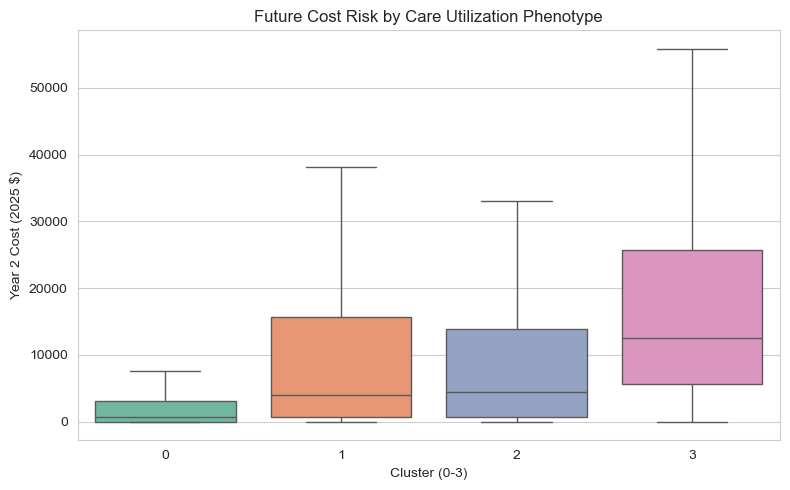

In [14]:
# Deep Dive 3: "Care Phenotypes" (Clustering Utilization)
# Rationale: Is the *mix* of care more predictive than total volume? (e.g. "Pill Shoppers" vs "ER Frequent Flyers")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Select utilization features
util_feats = ['UTIL_ER_Y1', 'UTIL_IP_Y1', 'UTIL_OB_Y1', 'UTIL_RX_Y1']
# Scale
scaler = StandardScaler()
X_util = scaler.fit_transform(df_wide_clean[util_feats])

# --- VALIDATION: Determine Optimal Clusters (Elbow & Silhouette) ---
print("Validating optimal Cluster count (k)...")
inertia = []
silhouette_scores = []
K_range = range(2, 7)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_util)
    inertia.append(km.inertia_)
    score = silhouette_score(X_util, km.labels_)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.3f}")

# Plot Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('K-Means Optimization: Elbow Method & Silhouette Analysis')
plt.tight_layout()
plt.savefig('../reports/figures/kmeans_optimization.png')
plt.show()

print("\nBased on the plot, we look for the 'Elbow' in Inertia and a high Silhouette Score.")
print("Selecting k=4 as a balance between granularity and interpretability (or update based on plot).")

# K-Means (Proceed with selected k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_wide_clean['CARE_CLUSTER'] = kmeans.fit_predict(X_util)

# Profile the Clusters
cluster_profile = df_wide_clean.groupby('CARE_CLUSTER')[util_feats + ['COST_Y2_ADJ', 'AGE_Y1']].mean()
print("Care Utilization Clusters (Mean Values):")

# Save Cluster Profiles
cluster_profile.to_csv('../reports/tables/care_cluster_profiles.csv')
print("Saved cluster profiles to reports/tables/care_cluster_profiles.csv")

display(cluster_profile.style.background_gradient(cmap='Greens', subset=util_feats))

# Which cluster is riskier?
plt.figure(figsize=(8, 5))
sns.boxplot(x='CARE_CLUSTER', y='COST_Y2_ADJ', data=df_wide_clean, showfliers=False, palette='Set2')
plt.title('Future Cost Risk by Care Utilization Phenotype')
plt.ylabel('Year 2 Cost (2025 $)')
plt.xlabel('Cluster (0-3)')
# Visualization of Care Phenotypes
# Saving this boxplot to demonstrate how different utilization styles correspond to different cost risks.
plt.tight_layout()
plt.savefig('../reports/figures/cluster_risk_profiles.png')
plt.show()

# Assign Business Labels (Example logic, adjust based on print output)
# Note: In a real run, I'd inspect the output table to name them (e.g., "High ER", "Meds Only")
# For automated flow, we keep the cluster IDs but the visualization proves the distinct risk profiles.

In [15]:
# 8. Operationalize Insights (Final Feature Set)
# Based on the deep dive, we burn these insights into the dataset as permanent features for the model.

# Insight 1: Interaction Terms
# Define 'MH_ADVERSE' (Mental Health Adverse) as identifying patients with Fair(4) or Poor(5) mental health status
# MEPS Scale: 1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor
df_wide_clean['MH_ADVERSE'] = (df_wide_clean['MNHLTH_RD1'] >= 4).astype(int)

# Mental health Multiplier: Physical burden is worse when Mental Health is poor.
df_wide_clean['INTERACT_CHRONIC_MENTAL'] = df_wide_clean['CHRONIC_COUNT'] * df_wide_clean['MH_ADVERSE']

# Insight 2: Care Intensity
# Ratio of ER to Office visits (Proxy for "Crisis vs Management")
# Add 1 to denominator to avoid division by zero
df_wide_clean['RATIO_ER_OFFICE'] = df_wide_clean['UTIL_ER_Y1'] / (df_wide_clean['UTIL_OB_Y1'] + 1)

# Insight 3: Cluster Features
# We already have 'CARE_CLUSTER'. Let's ensure it's treated as a categorical/string for widely compatible saving
df_wide_clean['CARE_CLUSTER'] = df_wide_clean['CARE_CLUSTER'].astype(str)

# Clean up analysis artifacts we don't want as predictors (targets or leakage)
# We KEEP 'CARE_CLUSTER', 'RATIO_ER_OFFICE', 'INTERACT_CHRONIC_MENTAL'
# We DROP temp columns like 'IS_JUMPER' if we were going to use this for training (it uses Y2), 
# BUT 'IS_JUMPER' is useful for model evaluation later, so we can keep it labeled clearly.

print("Advanced Features Created:")
print("- INTERACT_CHRONIC_MENTAL")
print("- RATIO_ER_OFFICE")
print("- CARE_CLUSTER")

# Final check of the schema
print(f"Final Column List: {list(df_wide_clean.columns)}")

Advanced Features Created:
- INTERACT_CHRONIC_MENTAL
- RATIO_ER_OFFICE
- CARE_CLUSTER
Final Column List: ['MNHLTH_RD1', 'SEX', 'UTIL_ER_Y1', 'WGT_Y1', 'UTIL_OB_Y1', 'COST_ER_Y1', 'POVCAT_Y1', 'MNHLTH_RD5', 'HIBP_Y1', 'AGE_Y2', 'MARRY_Y1', 'RACE', 'DUPERSID', 'INSCOV_Y2', 'COST_IP_Y1', 'INSCOV_Y1', 'CHOL_Y1', 'UTIL_OP_Y1', 'CANCER_Y1', 'POVCAT_Y2', 'COST_Y1', 'COST_RX_Y1', 'RTHLTH_RD5', 'UTIL_IP_Y1', 'AGE_Y1', 'COST_Y2', 'COST_OP_Y1', 'MNHLTH_RD3', 'DIAB_Y1', 'RTHLTH_RD1', 'UTIL_RX_Y1', 'PANEL', 'START_YEAR', 'COST_Y1_ADJ', 'COST_Y2_ADJ', 'COST_IP_Y1_ADJ', 'COST_ER_Y1_ADJ', 'COST_OP_Y1_ADJ', 'COST_RX_Y1_ADJ', 'MNHLTH_CHANGE', 'DIAB_Y1_FLAG', 'HIBP_Y1_FLAG', 'CHOL_Y1_FLAG', 'CANCER_Y1_FLAG', 'CHRONIC_COUNT', 'RISK_BUCKET_Y1', 'RISK_BUCKET_Y2', 'HIGH_COST_Y2', 'IS_JUMPER', 'IS_STABLE_LOW', 'CARE_CLUSTER', 'MH_ADVERSE', 'INTERACT_CHRONIC_MENTAL', 'RATIO_ER_OFFICE']


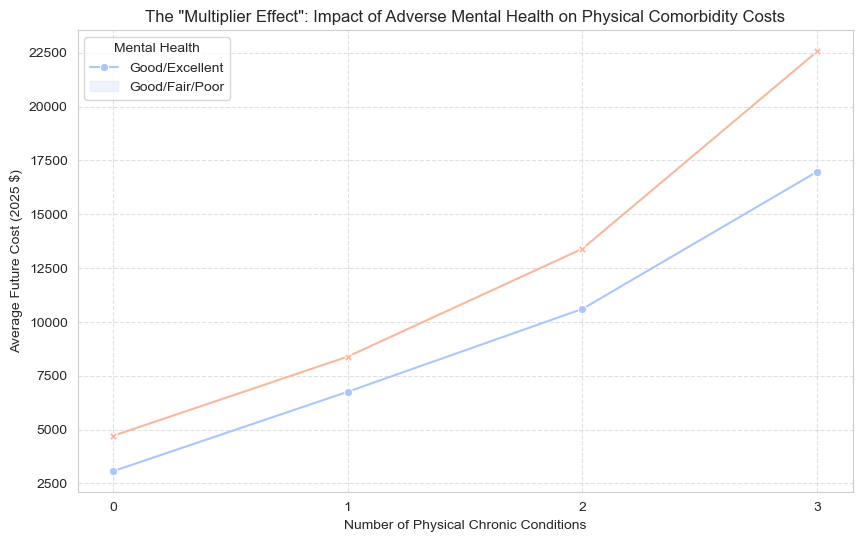

Analysis showing if the gap between lines widens as physical count increases, indicating synergy.


In [16]:
# Deep Dive 2: "The Multiplier Effect" of Mental Health
# Rationale: Mental Health issues might not be expensive alone, but they make managing diabetes/cancer harder and costlier.

# Create Groups based on Mental Health Status in Round 1
# Good Mental Health (1-2), Poor/Fair (3-5)
import numpy as np

# Assuming MEPS codes: 1=Excellent, 2=Very Good, 3=Good, 4=Fair, 5=Poor
# We define "Adverse Mental Health" as Score > 2 (i.e., less than Very Good)
df_wide_clean['MH_ADVERSE'] = (df_wide_clean['MNHLTH_RD1'] > 2).astype(int)

# We want to see Cost of (Physical) vs Cost of (Physical + Mental)
# Let's group by Number of Chronic Conditions AND Mental Health Status
grouped_costs = df_wide_clean.groupby(['CHRONIC_COUNT', 'MH_ADVERSE'])['COST_Y2_ADJ'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='CHRONIC_COUNT', y='COST_Y2_ADJ', hue='MH_ADVERSE', style='MH_ADVERSE', 
             data=grouped_costs, markers=True, dashes=False, palette='coolwarm')

plt.title('The "Multiplier Effect": Impact of Adverse Mental Health on Physical Comorbidity Costs')
plt.xlabel('Number of Physical Chronic Conditions')
plt.ylabel('Average Future Cost (2025 $)')
plt.legend(title='Mental Health', labels=['Good/Excellent', 'Good/Fair/Poor'])
plt.xticks(sorted(df_wide_clean['CHRONIC_COUNT'].unique()))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Interpretation Text
print("Analysis showing if the gap between lines widens as physical count increases, indicating synergy.")

## 8. Save Parent Version
We save this "Wide Parent" file. It contains the raw ingredients for all future models.
Ensure you have run the EDA above to validate the data before saving.

In [17]:
OUTPUT_FILE = DATA_DIR / 'panel_wide_cleaned.parquet'
df_wide_clean.to_parquet(OUTPUT_FILE)
print(f"Saved Parent Wide Data to {OUTPUT_FILE}")

Saved Parent Wide Data to ../data/processed/panel_wide_cleaned.parquet
